<style>
    .zero-margin {
        margin: 0 px;
     }
</style>

<div class="zero-margin" style="text-align: center;">
    <p style="text-align: center; font-size: 20px; margin-bottom: 10px;">Practice Case 05<p>
    <p style="text-align: center; font-size: 45px; margin: 0px; font-weight: bold;text-transform: uppercase;">Supervised Learning</p>
    <p  style="text-align: center; margin-bottom: 0px;">Monday, November 11th 2019</p>
     <p  style="text-align: center; margin-top: 0px;">M. Haries Ramdhani</p>
</div>

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit

pd.options.display.max_columns = 50
import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv("../data/pc05/train.csv")
df_test = pd.read_csv("../data/pc05/test.csv")

In [10]:
df_test["att10"] = np.nan

In [11]:
# Flag the test and train data so it can be easily distinguished in the future
df_test["flag_test"] = 1
df["flag_test"] = 0

In [12]:
df = df.append(df_test)

In [13]:
# Preview of the data frame
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8a,att8b,att8c,att8d,att8e,att8f,att8g,att8h,att8i,att8j,att9a,att9b,att9c,att10,flag_test
0,0.16,0.82,6,202,4,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0.0,0
1,0.43,0.48,2,153,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1.0,0
2,0.39,0.54,2,127,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1.0,0
3,0.73,1.00,5,253,6,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1.0,0
4,0.44,0.46,2,149,3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0,0


In [14]:
# gives some infos on columns types and number of null values
df_info = pd.DataFrame(df.dtypes).rename(columns={0:'data_type'})
df_info["#_unique"] = df.nunique()
df_info["#_nan"] = df.isnull().sum().astype(int)
df_info["%_nan"] = df.isnull().sum()/df.shape[0]*100

df_info.sort_values(by="#_unique", ascending=False)

,data_type,#_unique,#_nan,%_nan
att4,int64,215,0,0.0
att1,float64,92,0,0.0
att2,float64,65,0,0.0
att5,int64,8,0,0.0
att3,int64,6,0,0.0
att8g,int64,2,0,0.0
att10,float64,2,2000,20.0
att9c,int64,2,0,0.0
att9b,int64,2,0,0.0
att9a,int64,2,0,0.0


From this table we understood the following:
1. `att7` and `att6` are binary features
2. As stated in the slide the att10 is the label for the supervised learning
3. `att8`, `att9` are dummified categorical variables. `att8` has 10~11 categories and `att9` has 3~4 categories
4. The test size is 0.2

## Data Exploration

In [59]:
continuous_features = ["att4", "att1", "att2", "att5"]

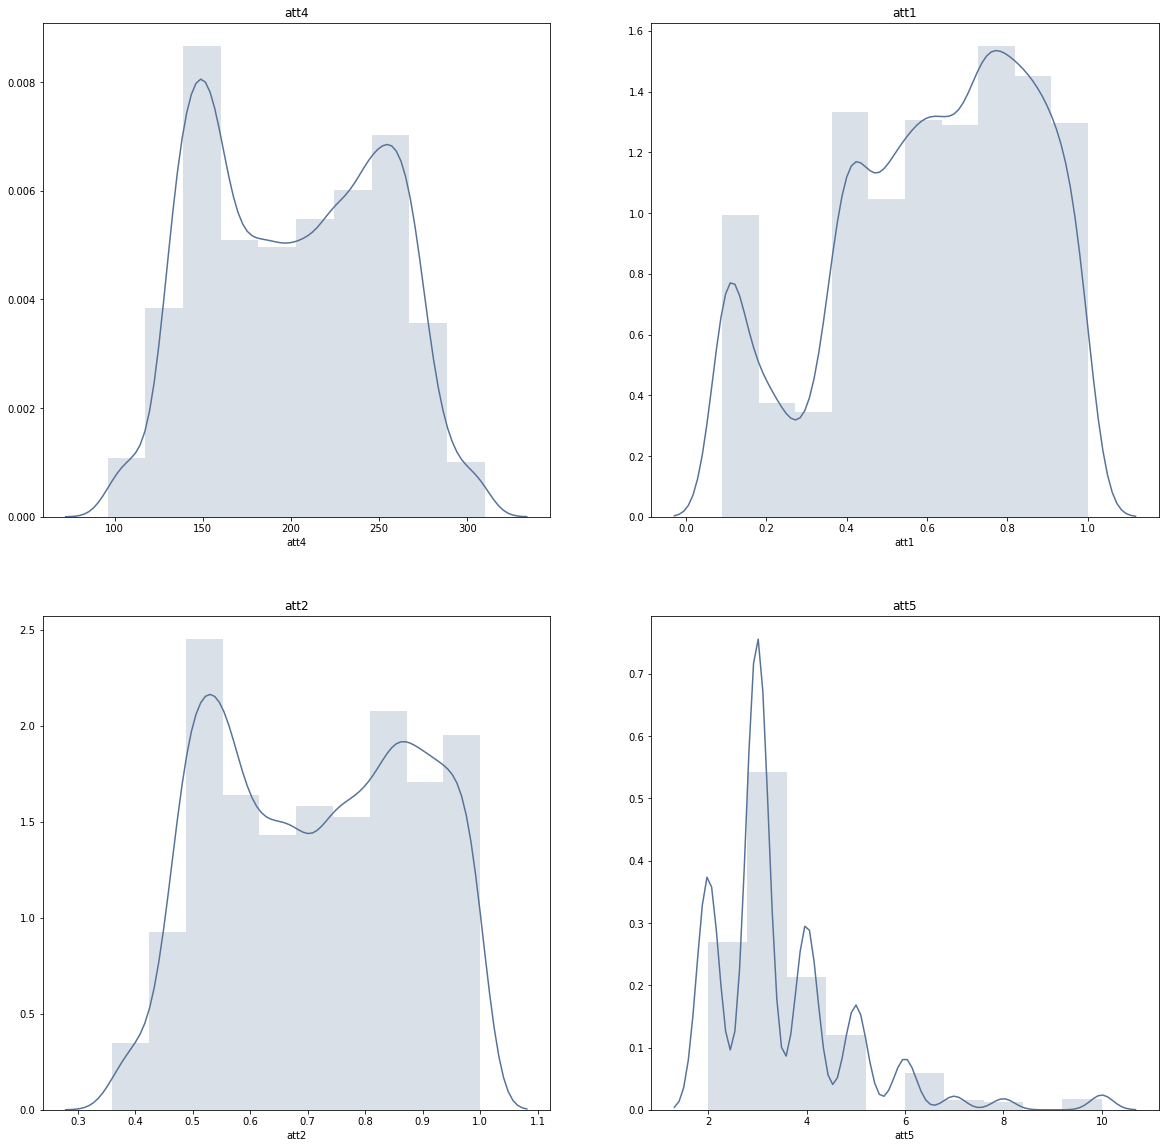

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for i, ax in enumerate(fig.axes):
    if i < len(continuous_features):
        sns.distplot(df[continuous_features[i]], hist=True, bins=10, ax=ax, hist_kws={"color": '#A3B2C7'}, kde_kws={"color": "#577399"})
        ax.set_title(continuous_features[i]) 

plt.show()

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [82]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [74]:
X = df[df["flag_test"] == 0].drop(["att10", "flag_test"], axis=1)
y = df[df["flag_test"] == 0]["att10"]

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [89]:
models = [
    {
        "instance" : KNeighborsClassifier(),
        "name": "KNN"
    }, {
        "instance" : DecisionTreeClassifier(),
        "name": "Decision Tree"
    }, {
        "instance" : LogisticRegression(),
        "name": "Logistic Regression"
    }, {
        "instance" : RandomForestClassifier(),
        "name": "Random Forest"
    }, {
        "instance" : AdaBoostClassifier(),
        "name": "Adaboost"
    }, {
        "instance" : XGBClassifier(),
        "name": "XGBoost"
    }
]

for (i, model) in enumerate(models):
    model["instance"].fit(X_train, y_train)
    
    y_pred_train =  model["instance"].predict(X_train)
    y_pred_test =  model["instance"].predict(X_test)
    
    auc_score_train = roc_auc_score(y_train, y_pred_train)
    models[i]["auc_train"] = auc_score_train
    
    auc_score_test = roc_auc_score(y_test, y_pred_test)
    models[i]["auc_test"] = auc_score_test
    
    accuracy_score_train = accuracy_score(y_train, y_pred_train)
    models[i]["accuracy_train"] = accuracy_score_train
    
    accuracy_score_test = accuracy_score(y_test, y_pred_test)
    models[i]["accuracy_test"] = accuracy_score_test
    
    f1_score_train = f1_score(y_train, y_pred_train)
    models[i]["f1_train"] = f1_score_train
    
    f1_score_test = f1_score(y_test, y_pred_test)
    models[i]["f1_test"] = f1_score_test

In [103]:
best_auc = max([(models[i]["name"], models[i]["auc_test"]) for i in range(len(models))], key=lambda x: x[1])
display(f"Model with the best AUC is {best_auc[0]} with AUC score of {round(best_auc[1], 2)}")

'Model with the best AUC is Random Forest with AUC score of 0.97'

In [105]:
ranks = sorted([(models[i]["name"], models[i]["auc_test"]) for i in range(len(models))], key=lambda x: x[1])

In [107]:
X_prediction = df[df["flag_test"] == 1].drop(["att10", "flag_test"], axis=1)

In [110]:
y_prediction = models[3]["instance"].predict_proba(X_prediction)

In [119]:
X_prediction["prediction_for_class_1"] = y_prediction[:, 1]

In [124]:
X_prediction_answer = X_prediction[["prediction_for_class_1"]].reset_index().rename(columns={"index": "no"})

In [125]:
X_prediction_answer["no"] += 1

In [127]:
X_prediction_answer.to_csv("answer.csv", index=False)